Exploring fMRI (func) DATA

In [1]:
import os
data_path = "ds005713-download/"
print(os.listdir(data_path))  # Explore downloaded dataset

['sub-13', 'sub-14', 'sub-026', 'sub-22', 'sub-010', 'sub-25', 'sub-017', 'sub-028', 'sub-035fu', 'sub-071fu', 'sub-088', 'sub-043', 'sub-044', 'sub-010fu', 'sub-086', 'sub-072', 'sub-40', 'sub-47', 'sub-081', 'sub-016', 'sub-24', 'sub-029', 'sub-23', 'sub-15', 'sub-020', 'sub-12', 'sub-080', 'sub-46', 'sub-074', 'sub-41', 'sub-073', 'sub-087', 'sub-48', 'sub-045', 'sub-089', 'sub-050fu', 'sub-042', 'sub-130', 'sub-137', 'sub-108', 'sub-101', '.DS_Store', 'sub-106', 'sub-082fu', 'sub-139', 'sub-104fu', 'sub-107', 'sub-138', 'sub-100', 'sub-100fu', 'sub-136', 'sub-109', 'sub-025fu', 'sub-072fu', 'sub-095fu', 'sub-113', 'sub-057fu', 'CHANGES', 'sub-114', 'sub-122', 'sub-125', 'sub-053fu', 'sub-117fu', 'sub-017fu', 'sub-124', 'sub-123', 'sub-115', 'sub-112', 'sub-094', 'sub-060', 'sub-067', 'sub-049fu', 'sub-058', 'sub-051', 'sub-028fu', 'sub-056', 'sub-043fu', 'sub-069', 'sub-30', 'sub-08', 'sub-37', 'sub-01', 'sub-39', 'sub-06', 'sub-057', 'sub-009fu', 'sub-068', 'sub-050', 'sub-085fu',

In [12]:
import nibabel as nib
dataset_path = "ds005713-download/"
func_file = os.path.join(dataset_path, "sub-01", "func", "sub-01_task-rest_bold.nii.gz")
func_img = nib.load(func_file)
func_data = func_img.get_fdata()
#3 spatial dimensions (x, y, z) and 1 temporal dimension (time)
print(f"fMRI data shape: {func_data.shape}")  # Example: (64, 64, 33, 120)

fMRI data shape: (80, 80, 45, 200)


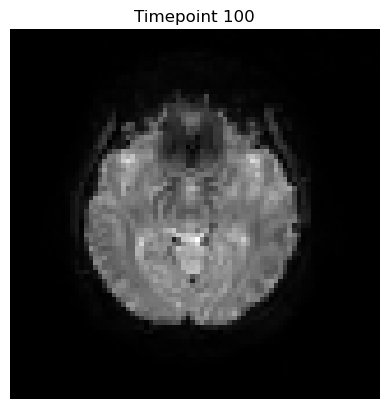

In [13]:
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt 

timepoint = 100  # Select a timepoint
slice_data = func_data[:, :, 20, timepoint]  # Adjust slice index
plt.imshow(slice_data.T, cmap="gray", origin="lower")
plt.title(f"Timepoint {timepoint}")
plt.axis("off")
plt.show()

In [21]:
import ants
import os
import nibabel as nib
import numpy as np
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt

# Paths
dataset_path = "ds005713-download/"
subject_id = "sub-01"
func_path = os.path.join(dataset_path, subject_id, "func", "sub-01_task-rest_bold.nii.gz")
anat_path = os.path.join(dataset_path, subject_id, "anat", "sub-01_run-01_T1w.nii.gz")
template_path = "/Users/egzonamorina/nilearn_data/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii.gz"

# Load images
print("Loading images...")
func_img = ants.image_read(func_path)
anat_img = ants.image_read(anat_path)
template_img = ants.image_read(template_path)

# Specify the timepoint to process
timepoint = 99  # 100th timepoint, as Python indexing starts at 0
func_data = func_img.numpy()

# Ensure timepoint is within range
assert 0 <= timepoint < func_data.shape[-1], "Timepoint is out of range."
print(f"Processing timepoint: {timepoint}")

# Extract the timepoint
func_slice = func_data[..., timepoint]
print(f"Extracted slice shape: {func_slice.shape}")

# Set origin and spacing for the slice
origin = (0, 0, 0)  # Default origin for the slice
spacing = func_img.spacing[:3]  # Use the first 3 dimensions of spacing

# Convert the slice into an ANTs image
func_slice_ants = ants.from_numpy(func_slice, origin=origin, spacing=spacing)

# Register anatomical to MNI
print("Registering anatomical image to MNI...")
reg_anat_to_mni = ants.registration(fixed=template_img, moving=anat_img, type_of_transform='Affine')

# Apply transforms to the extracted timepoint
print("Transforming functional slice to MNI...")
reg_func_slice_to_mni = ants.apply_transforms(
    fixed=template_img,
    moving=func_slice_ants,
    transformlist=reg_anat_to_mni['fwdtransforms'],
    imagetype=0  # 3D image
)

# Save the transformed timepoint
output_path = os.path.join(dataset_path, subject_id, "func", f"sub-01_task-rest_bold_MNI_t{timepoint+1:03d}.nii.gz")
ants.image_write(reg_func_slice_to_mni, output_path)
print(f"Saved transformed timepoint {timepoint+1} to {output_path}")

# --------------------------------------------------------------
# Load the registered functional image for further analysis
# --------------------------------------------------------------

# Load the registered functional image (3D) for the selected timepoint
print("Loading registered functional image...")
registered_func_img = nib.load(output_path)
registered_func_data = registered_func_img.get_fdata()

# Fetch the Harvard-Oxford atlas
print("Fetching Harvard-Oxford atlas...")
atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
atlas_img = atlas['maps']  # Use the atlas image directly
atlas_labels = atlas['labels']  # Region labels

# Resample the atlas to match the registered functional data space
print("Resampling atlas to match registered functional data...")
resampled_atlas = resample_to_img(atlas_img, registered_func_img, interpolation='nearest', force_resample=True)
resampled_atlas_data = resampled_atlas.get_fdata()

# Inspect alignment and resampling
print("Registered fMRI affine matrix:\n", registered_func_img.affine)
print("Atlas affine matrix after resampling:\n", resampled_atlas.affine)
print(f"Resampled atlas shape: {resampled_atlas_data.shape}")
print(f"Registered fMRI data shape: {registered_func_data.shape}")


Loading images...
Processing timepoint: 99
Extracted slice shape: (80, 80, 45)
Registering anatomical image to MNI...
Transforming functional slice to MNI...
Saved transformed timepoint 100 to ds005713-download/sub-01/func/sub-01_task-rest_bold_MNI_t100.nii.gz
Loading registered functional image...
Fetching Harvard-Oxford atlas...
[get_dataset_dir] Dataset found in /Users/egzonamorina/nilearn_data/fsl
Resampling atlas to match registered functional data...
Registered fMRI affine matrix:
 [[   1.    0.   -0.  -98.]
 [   0.    1.   -0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Atlas affine matrix after resampling:
 [[   1.    0.   -0.  -98.]
 [   0.    1.   -0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Resampled atlas shape: (197, 233, 189)
Registered fMRI data shape: (197, 233, 189)


/Users/egzonamorina/opt/anaconda3/envs/cirq-env/lib/python3.9/site-packages/nilearn/image/resampling.py:807: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Regions in slice 100:
 - Region 1.0: Background
 - Region 3.0: Insular Cortex
 - Region 4.0: Superior Frontal Gyrus
 - Region 6.0: Inferior Frontal Gyrus, pars triangularis
 - Region 7.0: Inferior Frontal Gyrus, pars opercularis
 - Region 17.0: Inferior Temporal Gyrus, temporooccipital part
 - Region 19.0: Superior Parietal Lobule
 - Region 20.0: Supramarginal Gyrus, anterior division
 - Region 21.0: Supramarginal Gyrus, posterior division
 - Region 22.0: Angular Gyrus
 - Region 28.0: Subcallosal Cortex
 - Region 29.0: Paracingulate Gyrus
 - Region 30.0: Cingulate Gyrus, anterior division
 - Region 31.0: Cingulate Gyrus, posterior division
 - Region 32.0: Precuneous Cortex
 - Region 43.0: Central Opercular Cortex
 - Region 48.0: Supracalcarine Cortex


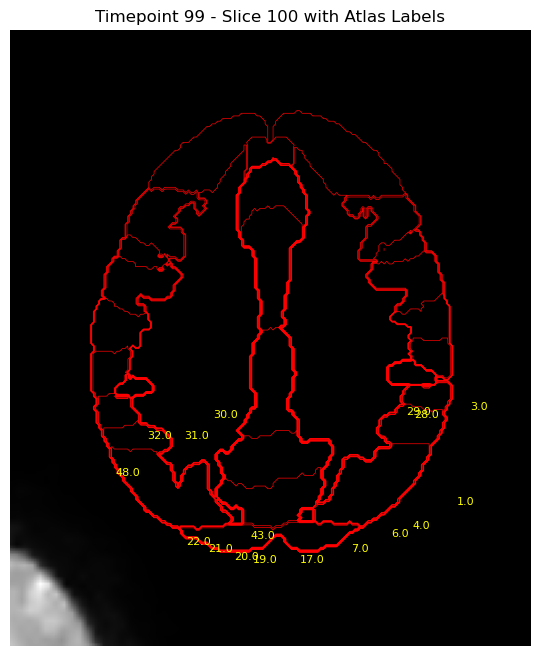

In [22]:
# Extract and print unique regions in a specific slice
slice_index = 100  # Example slice index for visualization
func_slice = registered_func_data[:, :, slice_index]
atlas_slice = resampled_atlas_data[:, :, slice_index]

unique_labels = np.unique(atlas_slice)
print(f"Regions in slice {slice_index}:")
for label in unique_labels:
    if label > 0:  # Exclude background
        region_name = atlas_labels[int(label) - 1]  # Adjust for 1-based indexing in atlas labels
        print(f" - Region {label}: {region_name}")

# Visualize the slice with atlas overlay
plt.figure(figsize=(10, 8))
plt.imshow(func_slice.T, cmap="gray", origin="lower")
plt.contour(atlas_slice.T, levels=np.unique(atlas_slice), colors='red', linewidths=0.5)
for label in unique_labels:
    if label > 0:
        region_name = atlas_labels[int(label) - 1]
        # Find a point inside the region to label (simplified here)
        coords = np.column_stack(np.where(atlas_slice == label))
        if coords.size > 0:
            y, x = coords[0]  # Take the first pixel in the region for simplicity
            plt.text(x, y, f"{label}", color='yellow', fontsize=8, ha='center')

plt.title(f"Timepoint {timepoint} - Slice {slice_index} with Atlas Labels")
plt.axis("off")
plt.show()


In [14]:
# Output video file path
output_video_path = os.path.join(dataset_path, "fmri_video.avi")

# Set up video writer (adjust frame size to match your data)
frame_size = (func_data.shape[0], func_data.shape[1])  # X, Y dimensions of slices
fps = 10  # Frames per second
video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"XVID"), fps, frame_size)

# Loop through timepoints to create video frames
for timepoint in range(func_data.shape[3]):
    fmri_slice = func_data[:, :, slice_index, timepoint]
    atlas_slice = resampled_atlas_data[:, :, slice_index]

    # Create an overlay image
    plt.figure(figsize=(10, 8))
    plt.imshow(fmri_slice.T, cmap="gray", origin="lower")
    plt.imshow(atlas_slice.T, cmap="hot", alpha=0.5, origin="lower")
    plt.axis("off")

    # Save the current frame
    plt.savefig("temp_frame.png", bbox_inches="tight", pad_inches=0)
    plt.close()

    # Read the saved frame and write to video
    frame = cv2.imread("temp_frame.png")
    frame = cv2.resize(frame, frame_size)  # Ensure it matches video dimensions
    video_writer.write(frame)

# Release the video writer and clean up
video_writer.release()
os.remove("temp_frame.png")

print(f"Video saved to {output_video_path}")

Video saved to ds005713-download/fmri_video.avi
